In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import healpy as hp
import rubin_sim.maf as maf
from rubin_scheduler.scheduler.utils import CurrentAreaMap

['' 'LMC_SMC' 'bulgy' 'dusty_plane' 'euclid_overlap' 'lowdust' 'nes' 'scp'
 'virgo']


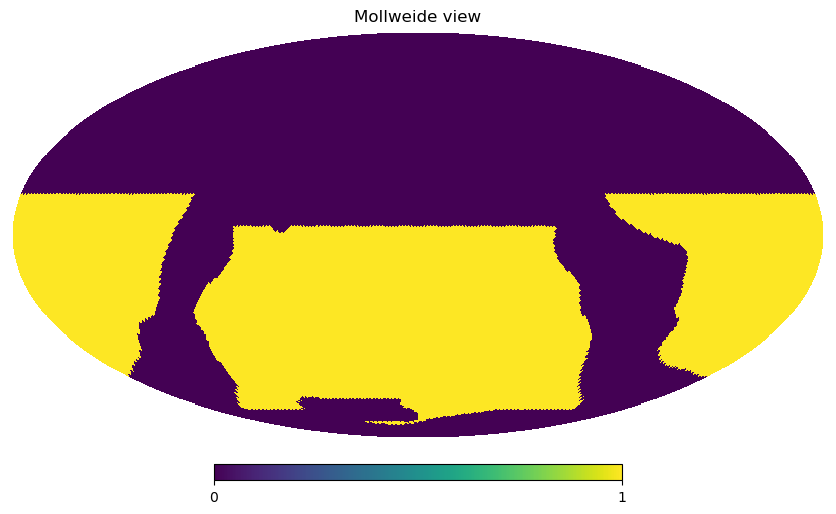

In [2]:
nside = 64
sky = CurrentAreaMap(nside=nside)
# footprints contains the goal weights per filter, for the sky (all survey modes together)
# labels contains the label (survey mode) for each healpix. 
footprints, labels = sky.return_maps()
print(np.unique(labels))

wfd_extragalactic = np.where((labels == "euclid_overlap") |  (labels =="lowdust"), 1, 0)
hp.mollview(wfd_extragalactic)

In [3]:
# You can look at the notes to see if there's anything you should explicitly reject
opsdb = '/Users/lynnej/opsim/fbs_4.0/baseline_v4.0_10yrs.db'
conn = sqlite3.connect(opsdb)

opsim = os.path.split(opsdb)[-1].replace('.db', '')
print(opsim, ":", opsdb)
visits = pd.read_sql('select * from observations', conn)
ovisitsnp = visits.to_records(index=False)

if "scheduler_note" not in visits.columns:
    print("using an older simulation so probably need to use 'note' instead of 'scheduler_note'")

note_col = 'scheduler_note'

baseline_v4.0_10yrs : /Users/lynnej/opsim/fbs_4.0/baseline_v4.0_10yrs.db


In [4]:
name = 'ExGal'

# label the visits based on their spatial location using the WFDlabelStacker
# https://github.com/lsst/rubin_sim/blob/3c307d33dcae0a89de7a6925debb8acf7e120606/rubin_sim/maf/stackers/label_stackers.py#L9
footpt = np.where((labels == 'lowdust') | (labels == 'euclid_overlap'), 1, 0)
stacker = maf.WFDlabelStacker(footprint=footpt, area_id_name=name, exclude_dd=False)
ovisitsnp = stacker.run(sim_data=ovisitsnp)

In [5]:
# Now ovisitsnp has all visits which lie in the extragalactic WFD area labeled as "WFD" 
# But you probably still want to reject non-wfd mode visits so we'll just flip those back
labelled_visits = pd.DataFrame(ovisitsnp)

In [6]:
print([n for n in labelled_visits[note_col].unique() if 'ToO' not in n])
labelled_visits[['scheduler_note', 'area_id']].groupby('scheduler_note').area_id.unique()

['blob_long, gr, a', 'blob_long, gr, b', 'pair_33, ug, a', 'pair_33, ug, b', 'long', 'twilight_near_sun, 0', 'twilight_near_sun, 1', 'twilight_near_sun, 2', 'twilight_near_sun, 3', 'greedy', 'pair_15, iz, a', 'pair_15, iz, b', 'DD:COSMOS', 'pair_15, ri, a', 'pair_15, ri, b', 'pair_33, gr, a', 'pair_33, gr, b', 'pair_15, yy, a', 'pair_15, yy, b', 'pair_33, ri, a', 'pair_33, ri, b', 'pair_33, zy, a', 'pair_33, zy, b', 'pair_33, yy, a', 'pair_33, yy, b', 'pair_15, zy, a', 'pair_15, zy, b', 'blob_long, iz, a', 'blob_long, iz, b', 'pair_33, iz, a', 'pair_33, iz, b', 'pair_33, ur, a', 'pair_33, ur, b', 'DD:ELAISS1', 'blob_long, ri, a', 'blob_long, ri, b', 'DD:XMM_LSS', 'DD:EDFS_a', 'DD:EDFS_b', 'DD:ECDFS', 'DD: RGES_onseason', 'DD: RGES_offseason']


scheduler_note
DD: RGES_offseason             [NULL]
DD: RGES_onseason              [NULL]
DD:COSMOS                     [ExGal]
DD:ECDFS                      [ExGal]
DD:EDFS_a                     [ExGal]
                            ...      
pair_33, zy, b          [ExGal, NULL]
twilight_near_sun, 0    [ExGal, NULL]
twilight_near_sun, 1    [ExGal, NULL]
twilight_near_sun, 2    [ExGal, NULL]
twilight_near_sun, 3    [ExGal, NULL]
Name: area_id, Length: 1508, dtype: object

In [7]:
query = f"({note_col}.str.contains('DD')) or ({note_col}.str.contains('twilight')) or ({note_col}.str.contains('ToO'))"
special_mode = visits.query(query)
col_id = np.where(labelled_visits.columns.values == "area_id")[0][0]
labelled_visits.iloc[special_mode.index, col_id] = 'NULL'

In [8]:
labelled_visits.head()

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,...,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id,observation_reason,science_program,area_id
0,0,200.782211,-50.116498,60796.001439,60796.068648,29.2,r,142.995018,0.0,2,...,83.711608,29.111132,128.922776,142.152585,24.587034,132.523734,0,,,ExGal
1,1,204.232107,-51.991147,60796.001885,60796.068648,29.2,r,142.513540,0.0,2,...,83.717806,29.110360,131.032507,141.364093,24.589708,134.815659,0,,,NULL
2,2,207.940418,-53.783599,60796.002331,60796.068648,29.2,r,141.167403,0.0,2,...,83.724012,29.109586,133.059975,140.381429,24.592386,136.960725,0,,,NULL
3,3,203.082640,-54.987835,60796.002778,60796.068648,29.2,r,146.759369,0.0,2,...,83.730237,29.108808,130.102187,138.329174,24.595072,139.141162,0,,,NULL
4,4,207.055974,-56.848274,60796.003224,60796.068648,29.2,r,145.009266,0.0,2,...,83.736461,29.108030,132.046197,137.294965,24.597759,141.153789,0,,,NULL


In [13]:
newdb = f'exgal_labelled_{opsim}.db'
if os.path.isfile(newdb):
    os.remove(newdb)
    
conn = sqlite3.connect(newdb)

labelled_visits.to_sql(name='observations', con=conn, index=False)

2038634

In [14]:
!ls $newdb

exgal_labelled_baseline_v4.0_10yrs.db


In [ ]:
# lynnej@tama notebooks % sqlite3 exgal_labelled_baseline_v4.0_10yrs.db 
# SQLite version 3.45.3 2024-04-15 13:34:05
# Enter ".help" for usage hints.
# sqlite> select * from observations limit 1;
# 0|200.782210821212|-50.1164984340556|60796.0014392263|60796.0686481482|29.2|r|142.995017640325|0.0|2|1.37960737879413|0.78353725168396|1.19302564834337|1.03266708293825|21.0279565795215|0|124.349156223464|33.6|45.9675478977889|23.9438499398853|46.5327792596511|132.733199166703|277.092454740965|-82.8394295681317|0.125|4.34377657911936|-25.0323607709486||blob_long, gr, a||1|148.947367621645|44.1655527915437|0.0|307.54443047623|273.457997458161|38.1092631808875|14.9774602028322|83.7116078104931|29.1111317773701|128.922776167818|142.152584989914|24.587033631459|132.523734335195|0|||ExGal
# sqlite> select distinct(area_id) from observations;
# ExGal
# NULL
# sqlite> 
